# Exploring Wikipedia clickstream data     

## Data quality analysis  

### 1. Introduction  

This notebook contains data quality analysis of all Wikipedia clickstream datasets available at [Wikimedia's clickstream data dump](https://dumps.wikimedia.org/other/clickstream/) as of January 2019.  
It is the first part of my project about usage patterns of Wikipedia.  

In the analyses below, we'll look at the size, shape and structure of the raw datasets, and find and fix any problems or anomalies in the raw data.


#### Notebook contents:  

1. [Introduction](#1.-Introduction)  
2. [Notebook setup](#2.-Notebook-setup)  
3. [Data sources](#3.-Data-sources)  
4. [Sample raw data file](#4.-Sample-raw-data-file)  
5. [DQA summary](#5.-DQA-summary)
6. [Next steps](#6.-Next-steps)

### 2. Notebook setup  
#### Imports

In [247]:
import re

import requests

# import html parsers before BeautifulSoup
import lxml

from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

from timeit import default_timer as timer

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import powerlaw

#### Settings

In [208]:
# Customize matplotlib default settings
matplotlib.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,10)

In [218]:
# set up Pandas options
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 50)
pd.set_option('display.precision', 3)
pd.options.display.float_format = '{:.2f}'.format

### 3. Data sources

[The Wikipedia clickstream datasets dump](https://dumps.wikimedia.org/other/clickstream/) contains monthly Wikipedia clickstream data dumps for a selection of top Wikipedia languages by Wikipedia size. The earliest datasets available are for November 2017 for the following 5 languages: German, English, Spanish, Japanese and Russian. In 2018, the list of languages has expanded to 11.

#### Listing all available Wikipedia clickstream datasets (as of January 2019)


The clickstream datasets are labelled by ISO language codes. The function below converts those codes to English.

In [138]:
# Helper function to convert ISO language codes to common language names
iso_language_codes_github_url = \
    "https://raw.githubusercontent.com/datasets/language-codes/master/data/language-codes.csv"
iso_language_codes = pd.read_csv(iso_language_codes_github_url)

def get_language_name(iso_language_code):
    return iso_language_codes.loc[iso_language_codes["alpha2"] == iso_language_code.lower()]["English"] \
                .values[0].split(";")[0]

A quick web scrape of the currently available dataset sizes, by month and language.

In [136]:
# Request the datasets dump page to get a list of month folders
clickstream_url = "https://dumps.wikimedia.org/other/clickstream/"
clickstream_url_response = requests.get(clickstream_url)

# Soup it
clickstream_url_soup = BeautifulSoup(clickstream_url_response.text)

In [145]:
# Scrape the months pages, and collect the datafiles info into a dict
# Note: this loops requests to the Wikimedia datadump pages, so don't rerun too frequently
datasets_dict = {}
for l in clickstream_url_soup.find_all("a"):
    month_folder_href_check = re.match(r"\d{4}-\d{2}/", l['href'])
    if month_folder_href_check:
        month_url = clickstream_url + l['href']
        month_response = requests.get(month_url)
        month_soup = BeautifulSoup(month_response.text)    
        files_list_raw = str(month_soup.find("pre"))
    
        month_dict = {}
        for row in files_list_raw.split("<a"):
            month_file_match = re.match(r".*(\w\w)wiki-\d{4}-\d{2}\..*\d\d:\d\d\s*(\d+)", row)
            if month_file_match:
                language_code, file_size_bytes = month_file_match.groups()
                #month_dict[get_language_name(language_code)] = f"{round(int(file_size_bytes)/1000000, 2)} MB"
                month_dict[get_language_name(language_code)] = round(int(file_size_bytes)/1000000, 2)
                
        datasets_dict[l['href'][:-1]] = month_dict

In [179]:
# Convert to dataframe
dataset_sizes_MB_zipped = pd.DataFrame.from_dict(datasets_dict, orient="index")

#### All available Wikipedia clickstream datasets by compressed file size, as of January 2019  
In the table below, the values are the compressed file sizes in MB. If a value is `NaN` in the table, then that file was not available.
The compressed file sizes are useful for seeing the relative dataset sizes over the different language domains and across time, but the actual uncompressed tsv files are much larger.

In [180]:
dataset_sizes_MB_zipped

,German,English,Spanish,Japanese,Russian,French,Italian,Polish,Portuguese,Chinese,Persian
2017-11,55.04,311.75,35.22,21.74,32.06,NaN,NaN,NaN,NaN,NaN,NaN
2017-12,54.56,318.82,33.12,21.73,32.04,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,59.43,347.51,35.12,22.03,32.42,38.02,34.86,18.76,16.12,9.34,NaN
2018-02,55.30,310.82,33.88,21.29,31.92,35.45,31.61,17.18,15.64,8.85,NaN
2018-03,59.10,333.40,37.22,23.06,33.74,38.64,33.46,18.10,19.16,11.44,3.46
2018-04,56.35,338.65,37.82,22.53,33.25,38.15,34.35,28.80,19.06,10.07,3.56
2018-05,56.39,341.20,39.04,23.25,33.58,39.23,36.44,17.97,18.56,10.88,3.60
2018-06,55.28,329.27,36.22,22.79,32.81,36.47,34.28,16.97,18.00,11.34,3.58
2018-07,57.99,347.89,36.08,22.70,32.94,36.74,32.59,16.60,17.18,10.03,3.81
2018-08,60.61,354.70,38.06,22.89,32.89,38.89,35.76,17.00,17.22,9.95,3.62


In [219]:
dataset_sizes_MB_zipped.describe()

,German,English,Spanish,Japanese,Russian,French,Italian,Polish,Portuguese,Chinese,Persian
count,14.00,14.00,14.00,14.00,14.00,12.00,12.00,12.00,12.00,12.00,10.00
mean,57.81,339.40,36.42,22.42,32.90,38.44,34.73,18.53,17.30,10.40,3.67
std,2.52,16.53,1.82,0.64,0.59,1.74,1.56,3.33,1.17,0.82,0.16
min,54.56,310.82,33.12,21.29,31.92,35.45,31.61,16.60,15.64,8.85,3.46
25%,55.52,330.30,35.14,21.81,32.52,37.37,34.08,16.99,16.42,10.01,3.56
50%,57.19,343.20,36.70,22.62,32.96,38.39,34.95,17.62,17.20,10.39,3.61
75%,60.21,353.00,37.73,22.87,33.33,39.46,35.85,18.40,18.14,11.00,3.79
max,62.10,361.07,39.04,23.25,33.74,41.23,36.55,28.80,19.16,11.44,3.96


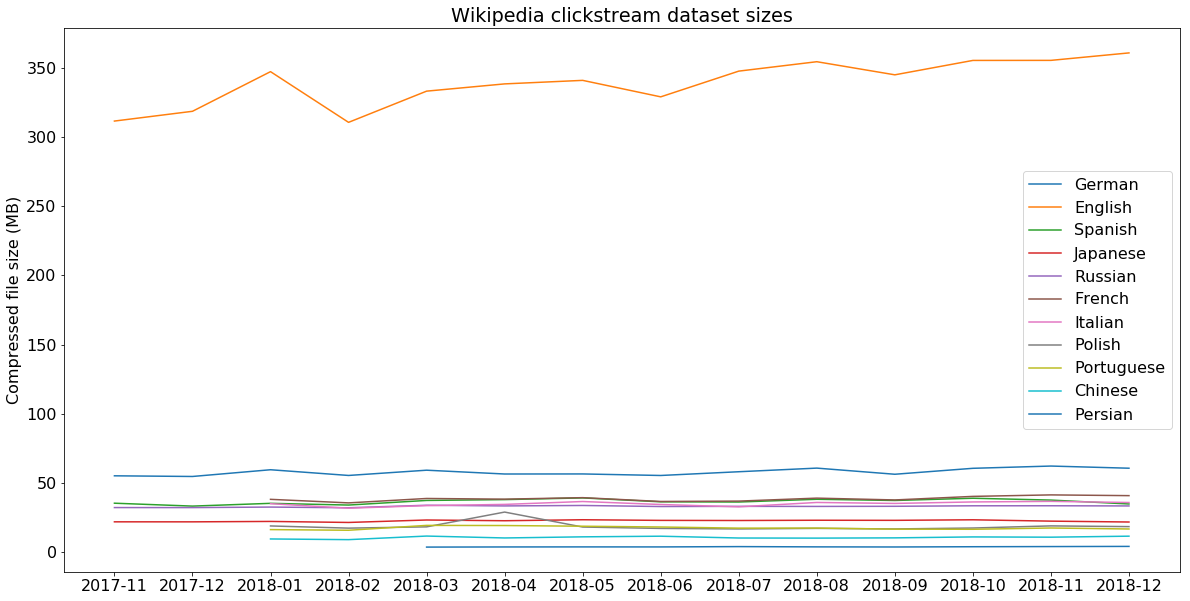

In [205]:
ax = plt.gca()
dataset_sizes_MB_zipped.plot(ax=ax)
plt.xticks(np.arange(len(dataset_sizes_MB_zipped.index)), dataset_sizes_MB_zipped.index)
ax.set_title("Wikipedia clickstream dataset sizes")
ax.set_ylabel("Compressed file size (MB)");

#### Zooming in on non-English Wikipedias

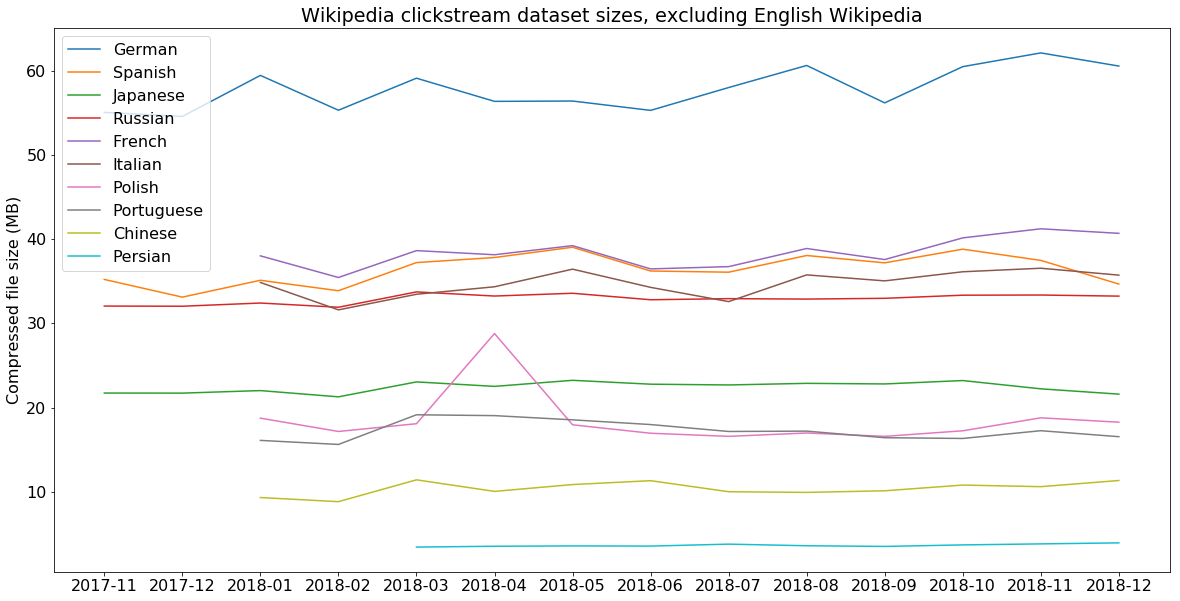

In [203]:
ax = plt.gca()
dataset_sizes_MB_zipped.drop('English', axis='columns').plot(ax=ax)
plt.xticks(np.arange(len(dataset_sizes_MB_zipped.index)), dataset_sizes_MB_zipped.index)
ax.set_title("Wikipedia clickstream dataset sizes, excluding English Wikipedia")
ax.set_ylabel("Compressed file size (MB)");

In [176]:
# Total count of clickstream data files available
sum(dataset_sizes_MB_zipped.count())

140

In [178]:
# Total size of the compressed files
print(sum(dataset_sizes_MB_zipped.sum())/1000, "GB")

8.31481 GB


#### Clickstream datasets summary
There are a total of 140 Wikipedia clickstream datasets currently available, spanning the last two months of 2017 and the entire year of 2018. The data is available for 5 languages in November and December of 2017, then the number of languages increases first to 10 in January 2018, and then to 11 in February 2018. 

The datasets are large. The English Wikipedia clickstream data is much larger than the rest, with German dataset sizes a distant second. The English Wikipedia clickstream data sizes are also the most variable. Overall, Wikipedia clickstream data sizes seem stable over time, with the exception of a sharp jump in Polish Wikipedia clickstream in April 2018.

#### Additional Wikipedia data

Wikimedia and Wikipedia provide lots of statistics and analytics resources on Wikipedia structure and usage that are a great starting point for further analyses.  
Here are a few:  
- [List of Wikipedias with some basic stats](https://en.wikipedia.org/wiki/List_of_Wikipedias#Detailed_list)
- [Wikimedia stats dashboard](https://stats.wikimedia.org/v2/#/all-projects)
- [Top views analysis tool](https://tools.wmflabs.org/topviews/)


### 4. Sample raw data file
The format of the Wikipedia clickstream datasets is described [here](https://meta.wikimedia.org/wiki/Research:Wikipedia_clickstream#Format), and should be uniform across the langauage domains and months. 

#### Let's examine the raw English Wikipedia clickstream dataset for the month of December 2018  

In [221]:
# Read the EN clickstream tsv file into pandas
filepath = "../data/clickstream-enwiki-2018-12.tsv"
start_time = timer()
df = pd.read_csv(filepath, sep='\t', names=['prev', 'curr', 'type', 'n'])
end_time = timer()
print("read_csv runtime:", (end_time - start_time)/60, "min\n")

read_csv runtime: 0.5469894766833022 min



In [222]:
# Check that the file was read in correctly
df.head()

,prev,curr,type,n
0,other-empty,2019_Horizon_League_Baseball_Tournament,external,16
1,other-search,ForeverAtLast,external,40
2,other-empty,ForeverAtLast,external,85
3,First_Families_of_Pakistan,Jehangir_Wadia,link,19
4,"The_Lawrence_School,_Sanawar",Jehangir_Wadia,link,36


In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29843928 entries, 0 to 29843927
Data columns (total 4 columns):
prev    object
curr    object
type    object
n       int64
dtypes: int64(1), object(3)
memory usage: 910.8+ MB


In [257]:
pd.options.display.float_format = '{:.0f}'.format 

# Describe the dataset
df.describe(include="all")

,prev,curr,type,n
count,29843928,29843928,29843928,29843928
unique,1714208,5183180,3,nan
top,other-empty,Hyphen-minus,link,nan
freq,5092856,127578,17849138,nan
mean,NaN,NaN,NaN,230
std,NaN,NaN,NaN,90309
min,NaN,NaN,NaN,10
25%,NaN,NaN,NaN,15
50%,NaN,NaN,NaN,28
75%,NaN,NaN,NaN,71


Looking at the dataframe description above, the counts for the `prev` and `curr` columns look off. According to [Wikipedia's data format description for this dataset](https://meta.wikimedia.org/wiki/Research:Wikipedia_clickstream#Format), we should not have any missing values, so all column value counts should equal the number of entries in the dataset. Let's take a look at the missing values in `prev` and `curr` columns.

In [226]:
df[df["prev"].isna()]

,prev,curr,type,n
24804,NaN,Denormal_number,link,26
785022,NaN,Hyphen-minus,other,10
1019421,NaN,Sodium_azide,link,35
3556686,NaN,Indeterminate_form,link,60
4748727,NaN,Imaginary_number,link,24
4754049,NaN,IEEE_754-2008_revision,link,18
5902556,NaN,IEEE_754,link,188
6525955,NaN,Undefined_behavior,link,18
7884601,NaN,Main_Page,other,23
10368848,NaN,Zero_to_the_power_of_zero,link,28


In [227]:
len(df[df["prev"].isna()])

22

In [228]:
df[df["curr"].isna()]

,prev,curr,type,n
5114052,JSON,NaN,link,104
5114053,other-external,NaN,external,447
5114054,Zero_to_the_power_of_zero,NaN,link,17
5114055,Signed_zero,NaN,link,34
5114056,Division_by_zero,NaN,link,72
5114057,IEEE_754-1985,NaN,link,50
5114058,Half-precision_floating-point_format,NaN,link,18
5114059,Magic_number_(programming),NaN,link,40
5114060,Double-precision_floating-point_format,NaN,link,69
5114061,other-internal,NaN,external,260


In [229]:
len(df[df["curr"].isna()])

22

In [230]:
df.loc[5114052]

prev    JSON
curr     NaN
type    link
n        104
Name: 5114052, dtype: object

In [231]:
# we want the output here to be string
type(df.loc[5114052]["curr"]) 

float

We seem to have some missing values in the data. Let's take a look in the input tsv file.

In [232]:
# check the datalines in the raw input file
!sed '5114050,5114055!d' ../data/clickstream-enwiki-2018-12.tsv

other-search	Auas_Mountains	external	19
other-empty	John_Bagley	external	12
other-search	John_Bagley	external	10
JSON	NaN	link	104
other-external	NaN	external	447
Zero_to_the_power_of_zero	NaN	link	17


From the raw tsv, it looks like NaN is not a missing value in the columns, but an actual Wikipedia article title, which indeed exists: [NaN wiki page](https://en.wikipedia.org/wiki/NaN).

Since Pandas does not treat the missing value NaN as a regular cateogrical value (it's excluded from counts, groupbys, etc.), we need to convert it to string. 

In [233]:
# Replace the false missing value NaNs with string "NaN"s
df['prev'] = df['prev'].fillna('NaN')
df['curr'] = df['curr'].fillna('NaN')

In [234]:
df.describe(include="all")

,prev,curr,type,n
count,29843928,29843928,29843928,29843928
unique,1714208,5183180,3,nan
top,other-empty,Hyphen-minus,link,nan
freq,5092856,127578,17849138,nan
mean,NaN,NaN,NaN,230
std,NaN,NaN,NaN,90309
min,NaN,NaN,NaN,10
25%,NaN,NaN,NaN,15
50%,NaN,NaN,NaN,28
75%,NaN,NaN,NaN,71


In [235]:
df.loc[5114052]

prev    JSON
curr     NaN
type    link
n        104
Name: 5114052, dtype: object

In [236]:
type(df.loc[5114052]["curr"]) 

str

The dataset description table above now looks fairly consistent with the data format description: no missing values, lots of unique `prev` and `curr` values, 3 unique values for link type, and a numerical link traffic volume field `n`, with a minimum cutoff at 10.  

Next, let's take a look at the distribution of link traffic volume values, to make sure that the distribution makes sense and to catch any data anomalies.

#### Page-to-page edge traffic distribution

In [239]:
df["n"].describe()

count    29843928
mean          230
std         90309
min            10
25%            15
50%            28
75%            71
max     492341152
Name: n, dtype: float64

From the univariate stats above, we can see that most page-to-page link traffic volumes over the course of December 2018 are quite low, with 50% of them being 28 or less. 

In [237]:
edge_traffic_frequencies = df["n"].value_counts()

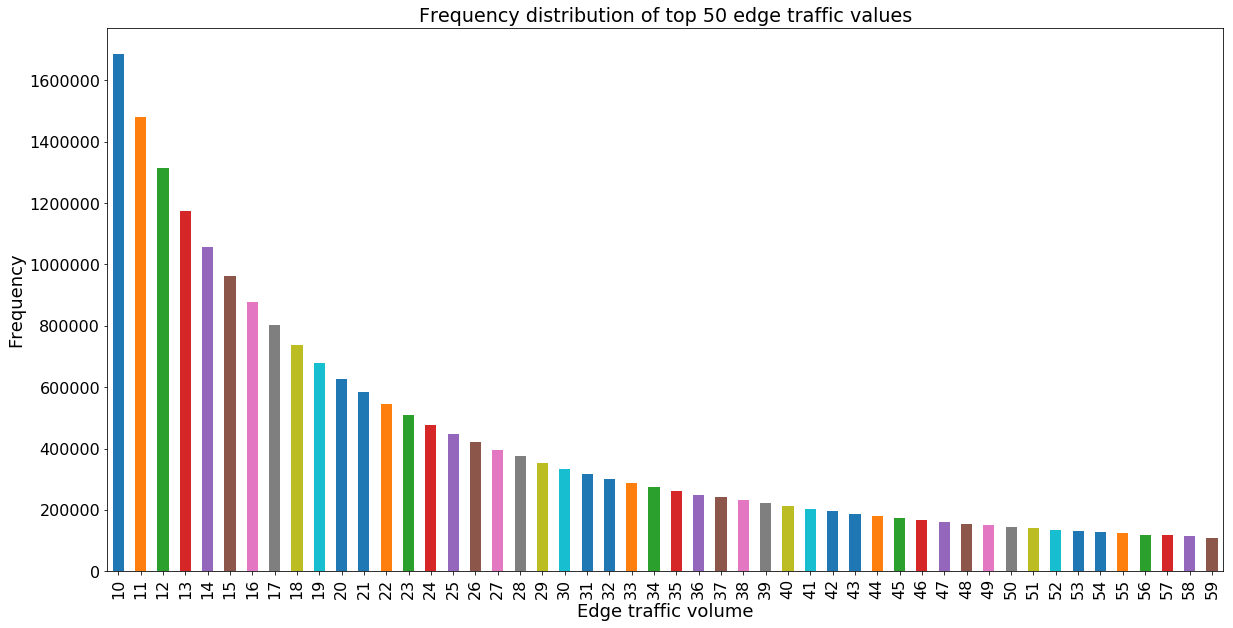

In [238]:
bar_chart = edge_traffic_frequencies.head(50).plot.bar(title="Frequency distribution of top 50 edge traffic values")
bar_chart.set_xlabel('Edge traffic volume', fontsize = 18)
bar_chart.set_ylabel('Frequency', fontsize = 18);

In [240]:
edge_traffic_rel_frequencies = edge_traffic_frequencies/len(df)

In [241]:
edge_traffic_rel_frequencies.values[:10]

array([0.05652721, 0.04960503, 0.04399119, 0.03934445, 0.03546021,
       0.03223332, 0.02937371, 0.02684831, 0.02471927, 0.02278809])

In [242]:
# Relative freq of edges with traffic volume of 20 or less
sum(edge_traffic_rel_frequencies.values[:11])

0.3819373575757186

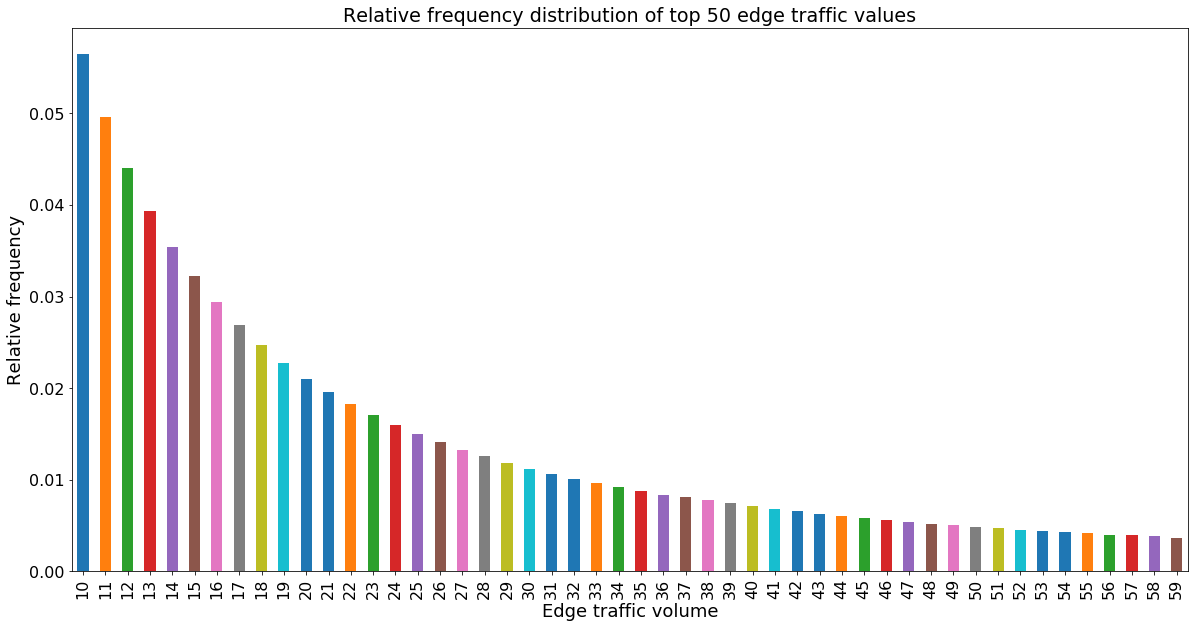

In [243]:
bar_chart = edge_traffic_rel_frequencies.head(50) \
    .plot.bar(title="Relative frequency distribution of top 50 edge traffic values")
bar_chart.set_xlabel('Edge traffic volume', fontsize = 18)
bar_chart.set_ylabel('Relative frequency', fontsize = 18);

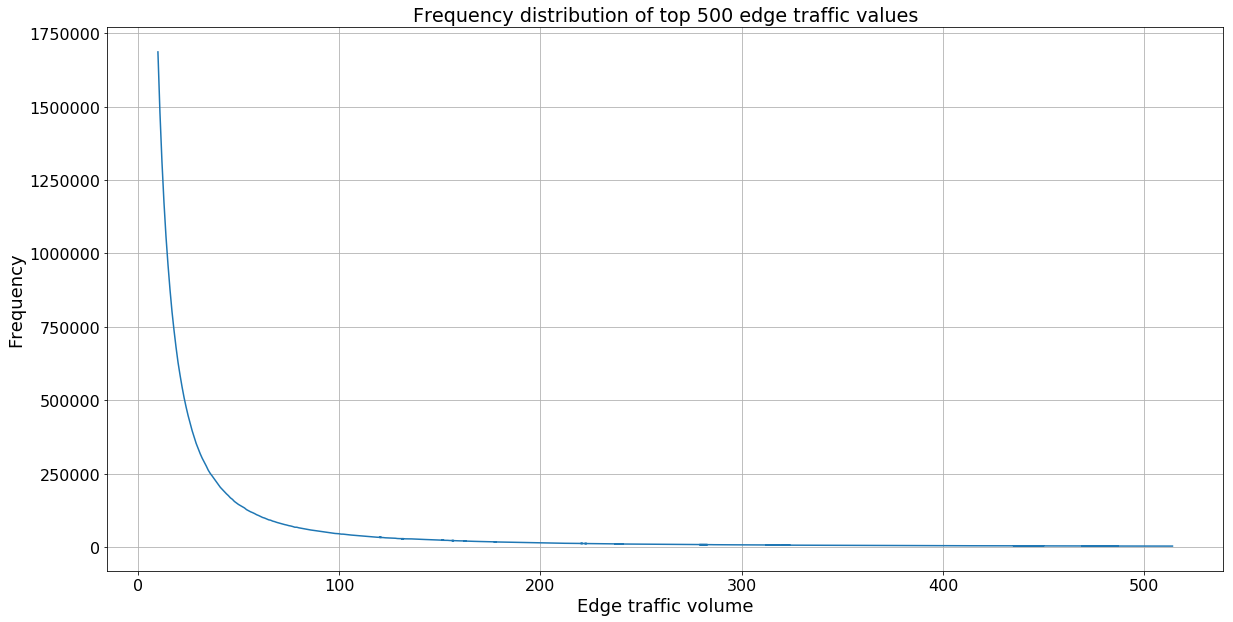

In [244]:
line_chart = edge_traffic_frequencies.head(500) \
    .plot.line(title="Frequency distribution of top 500 edge traffic values", grid=True)

line_chart.set_xlabel('Edge traffic volume', fontsize = 18)
line_chart.set_ylabel('Frequency', fontsize = 18);

The frequency distribution charts above show a long-tailed distribution, with highly frequent low values and low-frequency high values. This means that most page-to-page links were traversed a fairly small number of times in December 2018, while a few page-to-page links are traversed a very large number of times.  
This is consistent with what we would expect to see in network data, especially when it is a result of social network behavior. People tend to look up popular topics on Wikipedia, and so popular links are likely to be followed more and more as they become more popular.  

Processes like this can often be described with a power law distribution. A necessary (but not sufficient) condition for a power law distribution is that it looks like a line on a log-log scale.

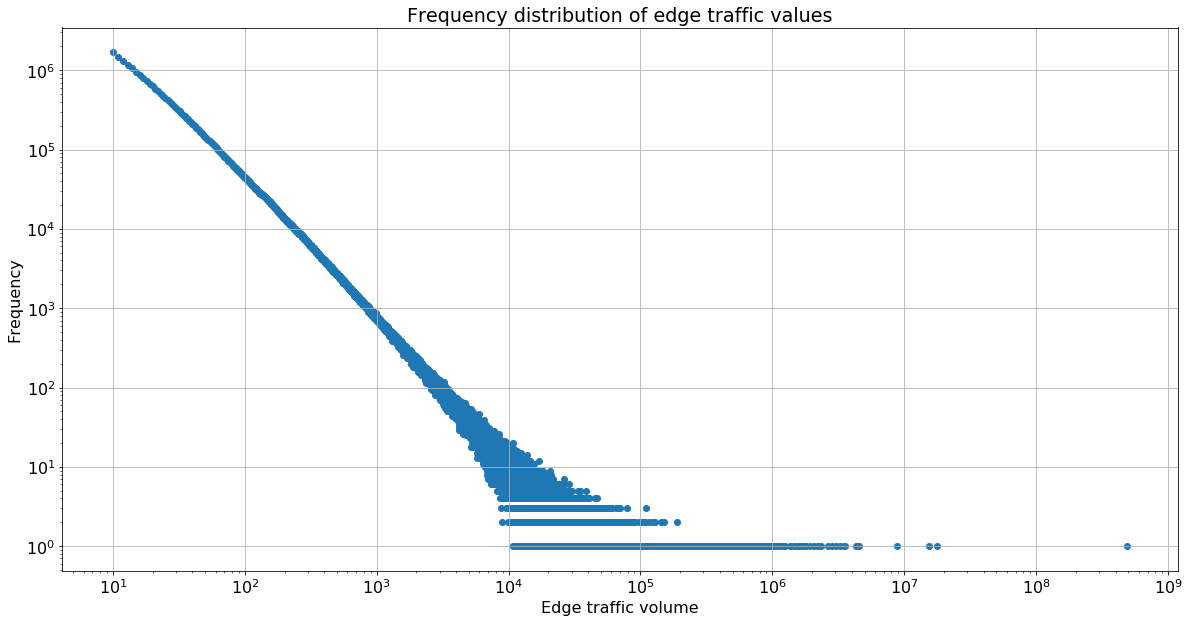

In [246]:
plt.scatter(edge_traffic_frequencies.index.values, edge_traffic_frequencies.values)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Edge traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of edge traffic values");

The log-log plot above shows something very close to a line for the lower values of link traffic volume, but the higher link traffic volume values fan out. The higher volume traffic values are messier, which would make it difficult to fit a line here. This can be addressed with logarithmic binning. We can do that and try to fit a powerlaw using the `powerlaw` package.

In [250]:
# numpy array of link traffic volume values
data = df["n"].values

In [251]:
start_time = timer()
results = powerlaw.Fit(data)
end_time = timer()
print("Runtime:", round((end_time - start_time)/60, 2), "min\n")

Calculating best minimal value for power law fit


Runtime: 30.67 min



In [252]:
print(results.power_law.alpha)
print(results.power_law.xmin)

2.7465478170902196
97984.0


In [253]:
R, p = results.distribution_compare('power_law', 'lognormal')

In [254]:
R

0.04186593354597434

In [255]:
p

0.544845625004867

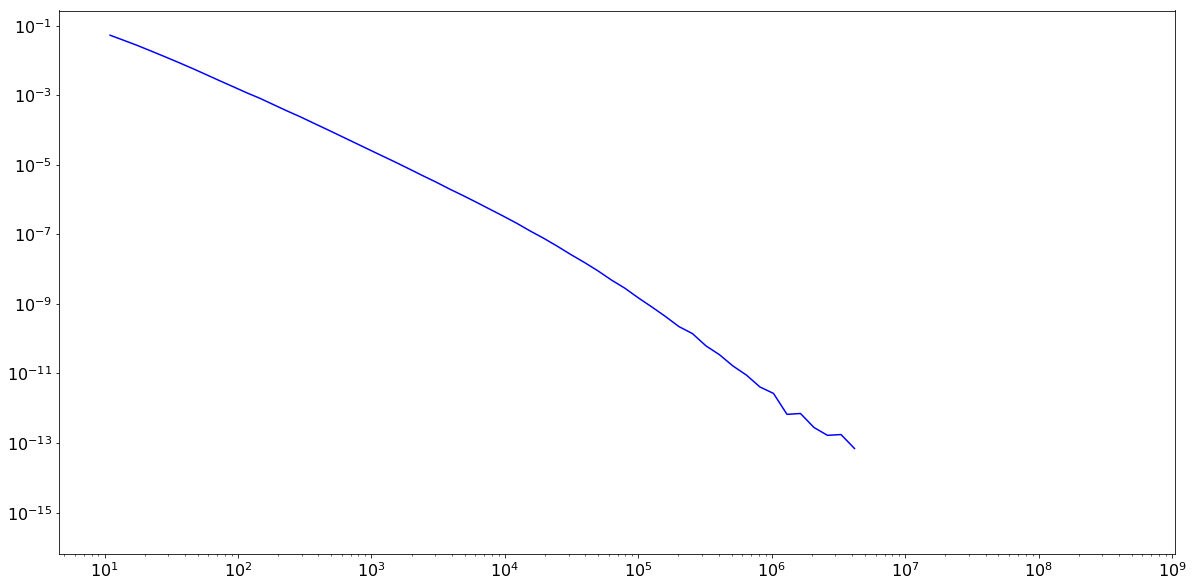

In [256]:
powerlaw.plot_pdf(data, color='b');

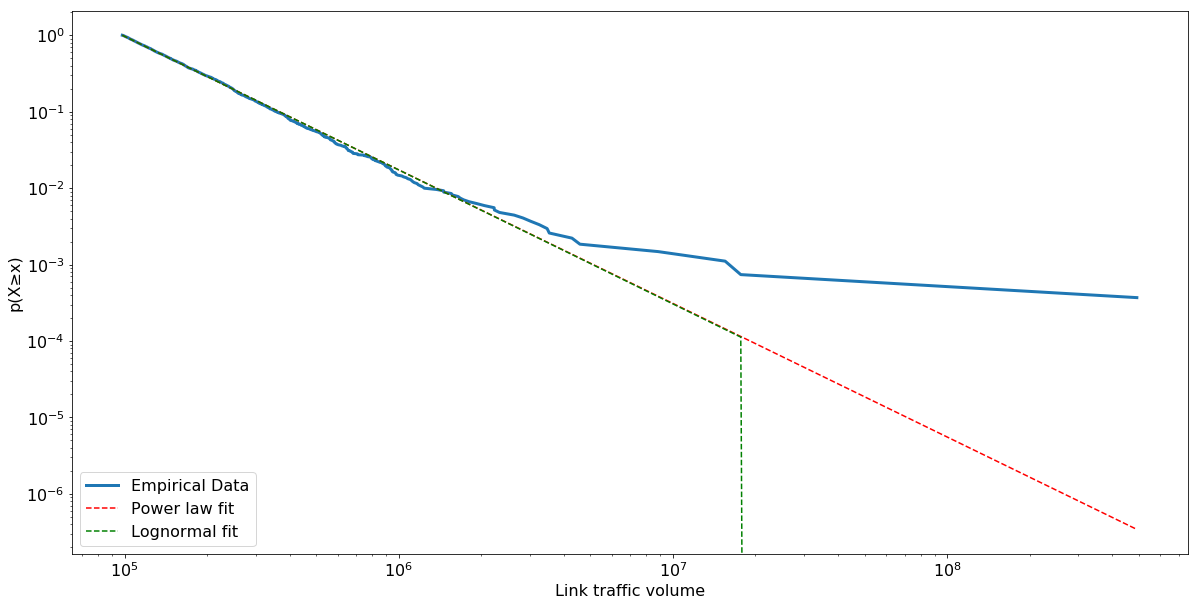

In [259]:

fig = results.plot_ccdf(linewidth=3, label='Empirical Data')
results.power_law.plot_ccdf(ax=fig, color='r', linestyle='--', label='Power law fit')
results.lognormal.plot_ccdf(ax=fig, color='g', linestyle='--', label='Lognormal fit')
####
fig.set_ylabel(u"p(X≥x)")
fig.set_xlabel("Link traffic volume")
handles, labels = fig.get_legend_handles_labels()
fig.legend(handles, labels, loc=3);

It looks like power law fits the data well for lower values of link traffic volume, but doesn't do so well for the extremely high link traffic values. And it looks like power law isn't a significantly better fit than a lognormal distribution for this data.  

So let's take a closer look at the edges with the highest traffic.

In [260]:
df_sorted = df.sort_values("n", ascending=False)

In [261]:
df_sorted.head(20)

,prev,curr,type,n
7908180,other-empty,Main_Page,external,492341152
772288,other-external,Hyphen-minus,external,17676430
765759,other-empty,Hyphen-minus,external,15498618
7831692,other-internal,Main_Page,external,8826536
21248650,other-search,George_H._W._Bush,external,4576854
3488262,other-empty,XHamster,external,4281194
23947949,other-search,Jason_Momoa,external,3538068
18399721,other-search,2.0_(film),external,3475113
1830737,other-search,Bird_Box_(film),external,3251996
7897786,other-search,Main_Page,external,3020671


The edges with the highest traffic volume are mostly starting outside of the English Wikipedia. 
The edge with the highest traffic volume has an empty referer going to English Wikipedia's [Main_Page](https://en.wikipedia.org/wiki/Main_Page). An empty referer could mean several things, from a bot to a security measure to a default browser homepage set to the Wikipedia's main page ([source](https://stackoverflow.com/questions/6880659/in-what-cases-will-http-referer-be-empty)).  
Similarly, the other top edges by traffic volume are coming from external searches, other Wikipedias, external websites and more empty referers. Compared to single article referers, these aggregate referer categories are likely to have high traffic volumes sinse they are sums of the traffic coming from those categories. In addition to the different level of aggregation, some of these external referer categories capture different user behavior. Opening a web browser to a default Wikipedia homepage is very different in terms of user behavior compared to following Wikipedia article links while researching a topic. These different user behavior processes and different levels of aggregation mixed in with the article-to-article traffic volumes probably explain much of the messiness of the high traffic volume data.  

Let's split out the `type=external` referers as a different kind of data, supplemental to the article-to-article network, but not part of its edges. 

In [303]:
edges_count = df_sorted.groupby("type").n.count()
edges_count.rename("edges_count", inplace=True)
traffic_volume = df_sorted.groupby("type").n.sum()
traffic_volume.rename("traffic_volume", inplace=True);

In [304]:
summary_by_type = pd.concat([edges_count, traffic_volume], axis=1)

In [305]:
summary_by_type["edges_count_pct"] = summary_by_type["edges_count"] / summary_by_type["edges_count"].sum()
summary_by_type["traffic_volume_pct"] = summary_by_type["traffic_volume"] / summary_by_type["traffic_volume"].sum()

In [306]:
# display 2 decimal pts
pd.options.display.float_format = '{:.2f}'.format

In [307]:
summary_by_type

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
type,,,,
external,10989706,5099833103,0.37,0.74
link,17849138,1718150529,0.60,0.25
other,1005084,60018652,0.03,0.01


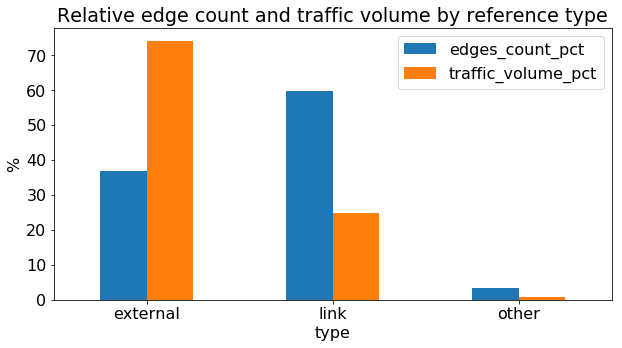

In [325]:
ax = plt.gca()
(summary_by_type[["edges_count_pct", "traffic_volume_pct"]]*100).plot(kind = "bar", ax=ax)
plt.xticks(np.arange(len(summary_by_type.index)), summary_by_type.index, rotation=0)
ax.set_title("Relative edge count and traffic volume by reference type")
ax.set_ylabel("%")

# adjust this fig size
fig = plt.gcf()
fig.set_size_inches(10,5);

About 74% of the traffic volume is coming from an external reference type (either an external website, an external search, another Wikimedia project, or an empty referer). 25% of the traffic volume is the article-to-article links, and the remaining 1% is the "other" reference type (which happens when the referer and the request are both Wikipedia articles, but not linked). The "other" reference type includes internal searching from a Wikipedia article page.  

The relatively low edges count for external reference type is not surprising, since those referers are aggregated into categories.

#### External reference edge traffic distribution  
(edges with type='external')

In [327]:
external_edges = df_sorted[df_sorted.type == 'external']

In [331]:
external_edges.describe(include="all")

,prev,curr,type,n
count,10989706,10989706,10989706,10989706.00
unique,5,5162523,1,nan
top,other-empty,Mundu,external,nan
freq,5092856,5,10989706,nan
mean,NaN,NaN,NaN,464.06
std,NaN,NaN,NaN,148814.37
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,18.00
50%,NaN,NaN,NaN,38.00
75%,NaN,NaN,NaN,121.00


In [332]:
external_edges_freq = external_edges.n.value_counts()

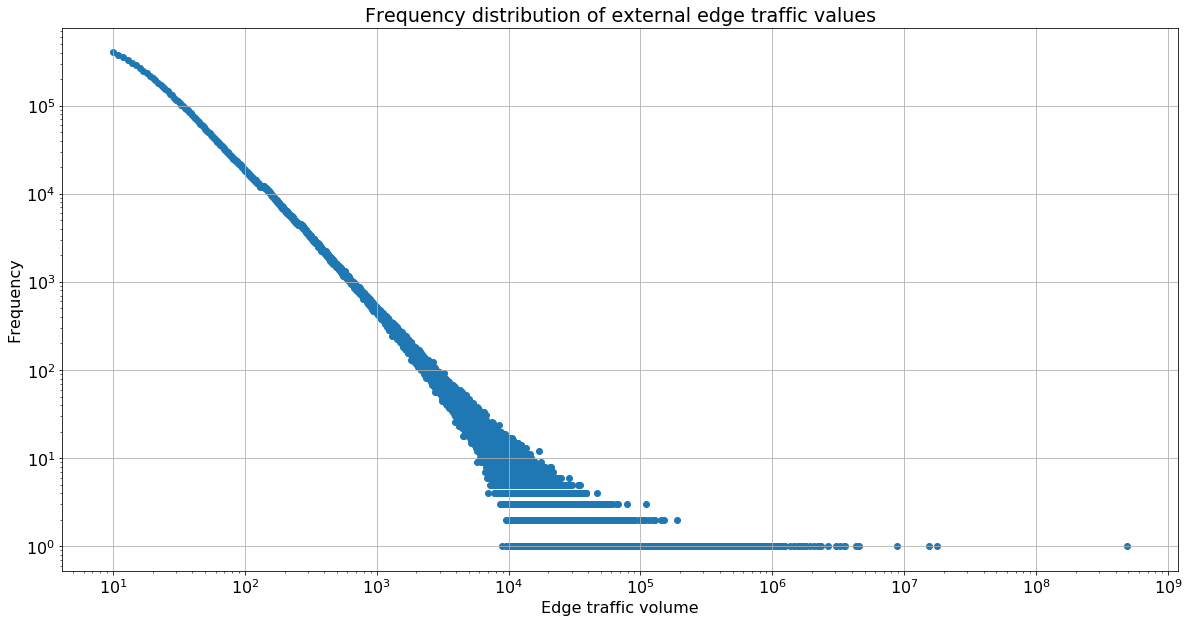

In [500]:
plt.scatter(external_edges_freq.index.values, external_edges_freq.values)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Edge traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of external edge traffic values");

In [338]:
edges_count = external_edges.groupby("prev").n.count()
edges_count.rename("edges_count", inplace=True)
traffic_volume = external_edges.groupby("prev").n.sum()
traffic_volume.rename("traffic_volume", inplace=True)
summary_by_prev = pd.concat([edges_count, traffic_volume], axis=1)

summary_by_prev["edges_count_pct"] = summary_by_prev["edges_count"] / summary_by_prev["edges_count"].sum()
summary_by_prev["traffic_volume_pct"] = summary_by_prev["traffic_volume"] / summary_by_prev["traffic_volume"].sum()

summary_by_prev

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
prev,,,,
other-empty,5092856,1779823892,0.46,0.35
other-external,787209,116723936,0.07,0.02
other-internal,1348733,132335737,0.12,0.03
other-other,374878,36968291,0.03,0.01
other-search,3386030,3033981247,0.31,0.59


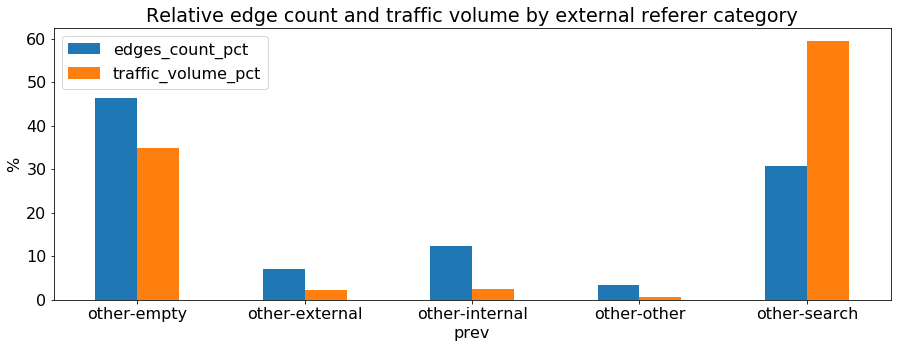

In [342]:
ax = plt.gca()
(summary_by_prev[["edges_count_pct", "traffic_volume_pct"]]*100).plot(kind = "bar", ax=ax)
plt.xticks(np.arange(len(summary_by_prev.index)), summary_by_prev.index, rotation=0)
ax.set_title("Relative edge count and traffic volume by external referer category")
ax.set_ylabel("%")

# adjust this fig size
fig = plt.gcf()
fig.set_size_inches(15,5);

59% of external edge traffic is coming from external searches, 35% has an empty referer, and the remaining external reference categories account for only 6% of the traffic volume.

##### External search referer category

In [343]:
external_search_edges = external_edges[external_edges.prev == "other-search"]
external_search_edges.describe(include="all")

,prev,curr,type,n
count,3386030,3386030,3386030,3386030.00
unique,1,3386029,1,nan
top,other-search,Live_at_the_London_Palladium,external,nan
freq,3386030,2,3386030,nan
mean,NaN,NaN,NaN,896.03
std,NaN,NaN,NaN,9169.64
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,24.00
50%,NaN,NaN,NaN,67.00
75%,NaN,NaN,NaN,269.00


In [344]:
external_search_edges_freq = external_search_edges.n.value_counts()

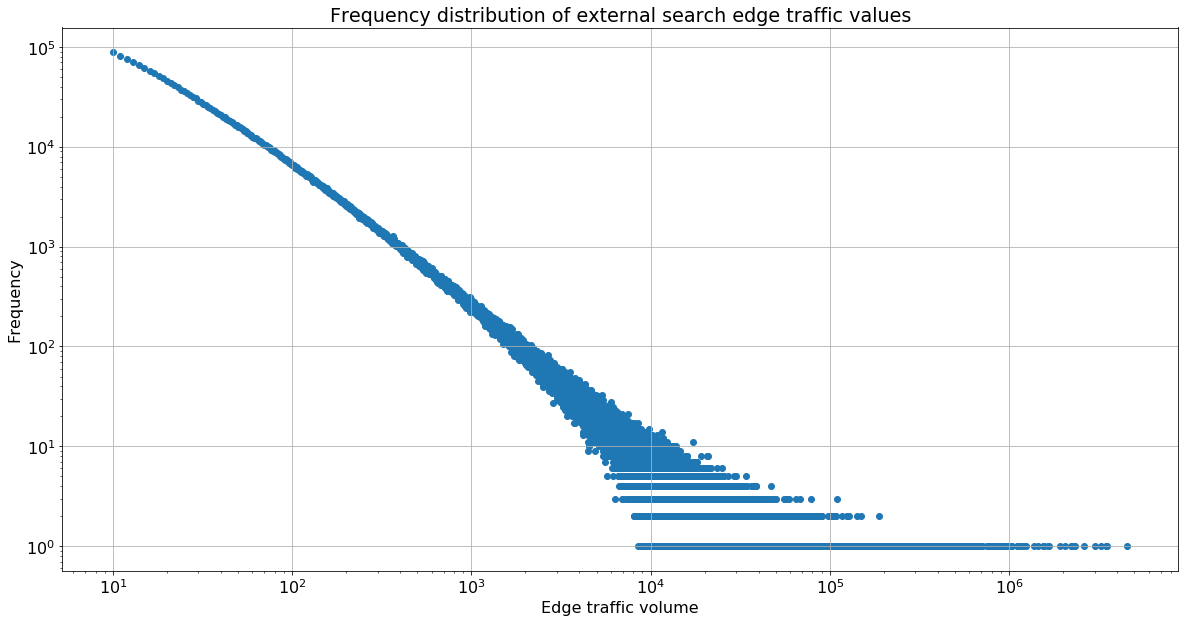

In [345]:
plt.scatter(external_search_edges_freq.index.values, external_search_edges_freq.values)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Edge traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of external search edge traffic values");

In [346]:
external_search_edges.head(20)

,prev,curr,type,n
21248650,other-search,George_H._W._Bush,external,4576854
23947949,other-search,Jason_Momoa,external,3538068
18399721,other-search,2.0_(film),external,3475113
1830737,other-search,Bird_Box_(film),external,3251996
7897786,other-search,Main_Page,external,3020671
5686277,other-search,Aquaman_(film),external,2634665
25643315,other-search,Bird_Box,external,2328884
4776244,other-search,Priyanka_Chopra,external,2231176
20225365,other-search,List_of_most-disliked_YouTube_videos,external,2226602
20505718,other-search,Freddie_Mercury,external,2050628


Looking at the outputs above, everything seems reasonable, except for the summary stats table showing that the 'curr' field contains a duplicate. Since the data is aggregated at (prev, curr) pair level, for a given 'prev' value all 'curr' values should be unique. Let's investigate these duplicates.

In [350]:
external_search_edges.curr.value_counts()[:10]

Live_at_the_London_Palladium                   2
IBM_Machine_Code_Printer_Control_Characters    1
Indiana_Hoosiers_baseball                      1
KRZD                                           1
Dead_Man's_Shoes                               1
Wu_Zhongchao                                   1
North_River_(Cacapon_River)                    1
Robin_Mathews_(poet)                           1
Cyril_Judd                                     1
Kula,_Hawaii                                   1
Name: curr, dtype: int64

In [351]:
external_search_edges[external_search_edges.curr == "Live_at_the_London_Palladium"]

,prev,curr,type,n
10213731,other-search,Live_at_the_London_Palladium,external,195
10612554,other-search,Live_at_the_London_Palladium,external,80


In [360]:
df[(df.curr == "Live_at_the_London_Palladium") & (df.type == "external")].sort_values("prev")

,prev,curr,type,n
10213727,other-empty,Live_at_the_London_Palladium,external,276
10612556,other-empty,Live_at_the_London_Palladium,external,48
10213726,other-internal,Live_at_the_London_Palladium,external,18
10213731,other-search,Live_at_the_London_Palladium,external,195
10612554,other-search,Live_at_the_London_Palladium,external,80


In [361]:
!sed '10213725,10213730!d' ../data/clickstream-enwiki-2018-12.tsv

Got_to_Give_It_Up	Live_at_the_London_Palladium	link	249
Here,_My_Dear	Live_at_the_London_Palladium	link	21
other-internal	Live_at_the_London_Palladium	external	18
other-empty	Live_at_the_London_Palladium	external	276
Marvin_Gaye_Live!	Live_at_the_London_Palladium	link	10
Marvin_Gaye_discography	Live_at_the_London_Palladium	link	152


In [362]:
!sed '10612550,10612560!d' ../data/clickstream-enwiki-2018-12.tsv

Flip_Saunders	Golden_Valley_Lutheran_College	link	32
other-search	Golden_Valley_Lutheran_College	external	47
Nikita_Koloff	Golden_Valley_Lutheran_College	link	15
other-empty	Golden_Valley_Lutheran_College	external	40
Liza_Minnelli	"Live"_at_the_London_Palladium	link	31
other-search	"Live"_at_the_London_Palladium	external	80
It_Amazes_Me	"Live"_at_the_London_Palladium	link	60
other-empty	"Live"_at_the_London_Palladium	external	48
Judy_Garland_discography	"Live"_at_the_London_Palladium	link	22
Liza_Minnelli_discography	"Live"_at_the_London_Palladium	link	10
other-search	Tyson_House_(Reno,_Nevada)	external	11


In [363]:
!perl -CSD -nE '$seen{$1}++ while /(\pP)/g; END { say "$_ $seen{$_}" for keys %seen }' ../data/clickstream-enwiki-2018-12.tsv | sort -k2rn

_ 88153311
- 13451944
) 5795602
( 5795187
. 1843781
, 1714937
' 743314
: 455138
– 383509
& 120137
! 108320
/ 94980
" 24458
? 22788
* 8520
— 3133
’ 2181
; 1463
@ 1260
% 992
‘ 858
¡ 569
… 370
′ 294
¿ 266
· 246
• 240
⟨ 76
⟩ 76
\ 73
” 69
“ 67
″ 34
» 23
‐ 22
« 15
§ 14
‑ 13
‒ 9
› 6
﹟ 6
： 5
‼ 4
॰ 3
・ 2
„ 1
† 1
‡ 1


In [396]:
!sed -n '/\"/p' ../data/clickstream-enwiki-2018-12.tsv | head -50

other-search	List_of_painters_by_name_beginning_with_"Z"	external	223
other-empty	List_of_painters_by_name_beginning_with_"Z"	external	74
List_of_painters_by_name	List_of_painters_by_name_beginning_with_"Z"	link	182
other-search	Steve_"Big_Man"_Clayton	external	36
other-empty	Steve_"Big_Man"_Clayton	external	24
other-empty	Fair_Wind,_"Blue_Bird"!	external	24
other-empty	King_Creosote_Says_"Buy_The_Bazouki_Hair_Oil"	external	18
Radge_Weekend_Starts_Here	King_Creosote_Says_"Buy_The_Bazouki_Hair_Oil"	link	10
Spanish_Legion	1st_Legion_Tercio_"Great_Captain_Gonzalo_Fernández_de_Córdoba"	link	73
Structure_of_the_Spanish_Army	1st_Legion_Tercio_"Great_Captain_Gonzalo_Fernández_de_Córdoba"	link	14
other-search	1st_Legion_Tercio_"Great_Captain_Gonzalo_Fernández_de_Córdoba"	external	45
other-empty	1st_Legion_Tercio_"Great_Captain_Gonzalo_Fernández_de_Córdoba"	external	33
other-internal	1st_Legion_Tercio_"Great_Captain_Gonzalo_Fernández_de_Córdoba"	external	11
other-empty	Parco_Botanico_Friulano_"

In [373]:
!sed -n '/\//p' ../data/clickstream-enwiki-2018-12.tsv | head -10

List_of_SNCB/NMBS_classes	SNCB_Class_50	link	24
Sitagliptin/metformin	Metformin	link	39
Carver_(Nip/Tuck)	Ryan_Murphy_(writer)	link	30
Pretty/Handsome	Ryan_Murphy_(writer)	link	16
List_of_Nip/Tuck_episodes	Ryan_Murphy_(writer)	link	18
Nip/Tuck	Ryan_Murphy_(writer)	link	534
Words_Are_Not_Enough/I_Know_Him_So_Well	Light_Up_the_World_(Steps_song)	link	32
List_of_500cc/MotoGP_Motorcycle_World_Champions	2014_MotoGP_season	link	39
Vickers_14_inch/45_naval_gun	Vickers	link	18
Group_f/64	Ansel_Adams	link	110
sed: stdout: Broken pipe


In [375]:
!sed -n '/\\/p' ../data/clickstream-enwiki-2018-12.tsv | head -10

other-empty	\/	external	23
other-empty	\\	external	33
other-external	\\	external	10
other-empty	Hawkins\Brown	external	40
other-search	Hawkins\Brown	external	45
Lee_Clow	TBWA\Chiat\Day	link	46
John_Doman	TBWA\Chiat\Day	link	21
Pets.com	TBWA\Chiat\Day	link	21
other-internal	TBWA\Chiat\Day	external	36
Jay_Chiat	TBWA\Chiat\Day	link	29


In [378]:
!sed -n '/\./p' ../data/clickstream-enwiki-2018-12.tsv | head -10

other-search	5.11_Tactical	external	4810
other-empty	5.11_Tactical	external	12988
The_Grand_Tour	5.11_Tactical	link	42
Tom_Davin	5.11_Tactical	link	18
other-internal	5.11_Tactical	external	132
Kilt	5.11_Tactical	link	42
other-other	5.11_Tactical	external	25
Police_duty_belt	5.11_Tactical	link	11
Main_Page	5.11_Tactical	other	27
other-external	5.11_Tactical	external	49
sed: stdout: Broken pipe


In [376]:
!sed -n '/§/p' ../data/clickstream-enwiki-2018-12.tsv | head -10

other-search	BÏF§ZF+18	external	41
Sodomy_laws_in_the_United_States	Section_839(a)_of_title_10_United_States_Code_§_925_-_Article_125.	link	15
other-empty	Section_839(a)_of_title_10_United_States_Code_§_925_-_Article_125.	external	24
LGBT_rights_in_New_York	9_New_York_Code_of_Rules_and_Regulations_§466.13	link	11
other-empty	9_New_York_Code_of_Rules_and_Regulations_§466.13	external	27
Collective_bargaining	11_U.S.C._§1113_–_Rejection_of_Collective_Bargaining_Agreements	link	15
other-search	11_U.S.C._§1113_–_Rejection_of_Collective_Bargaining_Agreements	external	22
other-empty	11_U.S.C._§1113_–_Rejection_of_Collective_Bargaining_Agreements	external	33
Monument_(Kollegah_album)	§185	link	17
other-empty	§185	external	43


In [401]:
!sed -n "/^'/p" ../data/clickstream-enwiki-2018-12.tsv | head -10

'Allo_'Allo!	René_Artois	link	15
'Til_Tuesday	Michael_Hausman	link	161
'Salem's_Lot	The_Dark_Tower_(series)	link	31
'Ndrangheta	Loan_shark	link	22
'Til_Death_Do_Us_Part_(film)	Stephen_Bishop_(actor)	link	228
'Ndrangheta	Hyphen-minus	other	10
'Asir_Region	Khalid_bin_Faisal_Al_Saud	link	15
'Allo_'Allo!	Gorden_Kaye	link	485
'68_(band)	Two_Parts_Viper	link	33
'Ndrangheta	Waste_management	link	39


In [403]:
df[df.prev == "'Allo_'Allo!"][:10]

,prev,curr,type,n
178720,'Allo_'Allo!,René_Artois,link,15
1074704,'Allo_'Allo!,Gorden_Kaye,link,485
1376326,'Allo_'Allo!,Richard_Gibson,link,172
2142268,'Allo_'Allo!,Nouvion,link,32
2385035,'Allo_'Allo!,Arthur_Bostrom,link,166
2468446,'Allo_'Allo!,Moira_Foot,link,21
2666122,'Allo_'Allo!,Jeremy_Lloyd,link,49
3626334,'Allo_'Allo!,Robin_Parkinson,link,91
5230396,'Allo_'Allo!,Roger_Kitter,link,87
5822037,'Allo_'Allo!,Kirsten_Cooke,link,217


In [387]:
df[df.curr == "\\\\"]

,prev,curr,type,n
3085484,other-empty,\\,external,33
3085485,other-external,\\,external,10


In [388]:
df[df.curr == 'List_of_painters_by_name_beginning_with_"Z"']

,prev,curr,type,n
14869,other-search,"List_of_painters_by_name_beginning_with_""Z""",external,223
14870,other-empty,"List_of_painters_by_name_beginning_with_""Z""",external,74
14871,List_of_painters_by_name,"List_of_painters_by_name_beginning_with_""Z""",link,182


In [395]:
df[df.curr == 'List_of_painters_by_name_beginning_with_Z']

,prev,curr,type,n


In [389]:
df[df.curr == '"Live"_at_the_London_Palladium']

,prev,curr,type,n


In [391]:
df[df.curr == '"Good_Hair"_and_Other_Dubious_Distinctions']

,prev,curr,type,n


In [394]:
df[df.curr == 'Good_Hair_and_Other_Dubious_Distinctions']

,prev,curr,type,n
333500,other-empty,Good_Hair_and_Other_Dubious_Distinctions,external,36


In [392]:
df[df.curr == 'Hold_It_Under_a_Faucet_7"']

,prev,curr,type,n
443019,other-empty,"Hold_It_Under_a_Faucet_7""",external,76


In [393]:
df[df.curr == 'Bart\'s_Dog_Gets_an_"F"']

,prev,curr,type,n
205902,The_Simpsons_(season_2),"Bart's_Dog_Gets_an_""F""",link,57
205903,Troy_McClure,"Bart's_Dog_Gets_an_""F""",link,54
205904,other-search,"Bart's_Dog_Gets_an_""F""",external,171
205905,Tracey_Ullman,"Bart's_Dog_Gets_an_""F""",link,42
205906,other-internal,"Bart's_Dog_Gets_an_""F""",external,17
205907,other-empty,"Bart's_Dog_Gets_an_""F""",external,156


It looks like a leading double quote in a field gets Pandas' read_csv to ignore the double quotes in the field, at least with the default settings. Since we'll need to read the data into neo4j later, which also views double quote as a field delimiter, we'll escape the escape and double quote characters in the data file to avoid import problems.

In [405]:
# escape backslashes first, and then double quotes
!sed -e 's/\\/\\\\/g' -e 's/"/\\"/g' ../data/clickstream-enwiki-2018-12.tsv >> ../data/clickstream-enwiki-2018-12_clean.tsv

In [407]:
!sed -n '/\"/p' ../data/clickstream-enwiki-2018-12_clean.tsv | head -50

other-search	List_of_painters_by_name_beginning_with_\"Z\"	external	223
other-empty	List_of_painters_by_name_beginning_with_\"Z\"	external	74
List_of_painters_by_name	List_of_painters_by_name_beginning_with_\"Z\"	link	182
other-search	Steve_\"Big_Man\"_Clayton	external	36
other-empty	Steve_\"Big_Man\"_Clayton	external	24
other-empty	Fair_Wind,_\"Blue_Bird\"!	external	24
other-empty	King_Creosote_Says_\"Buy_The_Bazouki_Hair_Oil\"	external	18
Radge_Weekend_Starts_Here	King_Creosote_Says_\"Buy_The_Bazouki_Hair_Oil\"	link	10
Spanish_Legion	1st_Legion_Tercio_\"Great_Captain_Gonzalo_Fernández_de_Córdoba\"	link	73
Structure_of_the_Spanish_Army	1st_Legion_Tercio_\"Great_Captain_Gonzalo_Fernández_de_Córdoba\"	link	14
other-search	1st_Legion_Tercio_\"Great_Captain_Gonzalo_Fernández_de_Córdoba\"	external	45
other-empty	1st_Legion_Tercio_\"Great_Captain_Gonzalo_Fernández_de_Córdoba\"	external	33
other-internal	1st_Legion_Tercio_\"Great_Captain_Gonzalo_Fernández_de_Córdoba\"	external	11
other-empty

In [408]:
# Read the cleaned up EN clickstream tsv file into pandas
filepath = "../data/clickstream-enwiki-2018-12_clean.tsv"
df_clean = pd.read_csv(filepath, sep='\t', names=['prev', 'curr', 'type', 'n'])

In [442]:
# Replace the false missing value NaNs with string "NaN"s
df_clean['prev'] = df_clean['prev'].fillna('NaN')
df_clean['curr'] = df_clean['curr'].fillna('NaN')

In [414]:
df_clean[df_clean.curr == '\\"Live\\"_at_the_London_Palladium']

,prev,curr,type,n
10612553,Liza_Minnelli,"\""Live\""_at_the_London_Palladium",link,31
10612554,other-search,"\""Live\""_at_the_London_Palladium",external,80
10612555,It_Amazes_Me,"\""Live\""_at_the_London_Palladium",link,60
10612556,other-empty,"\""Live\""_at_the_London_Palladium",external,48
10612557,Judy_Garland_discography,"\""Live\""_at_the_London_Palladium",link,22
10612558,Liza_Minnelli_discography,"\""Live\""_at_the_London_Palladium",link,10


In [418]:
df_clean[df_clean.curr == '\\\\\\\\']

,prev,curr,type,n
3085484,other-empty,\\\\,external,33
3085485,other-external,\\\\,external,10


In [443]:
df_clean_sorted = df_clean.sort_values("n", ascending=False)

In [444]:
external_edges = df_clean_sorted[df_clean_sorted.type == 'external']

##### Empty referer category

In [445]:
empty_referer_edges = external_edges[external_edges.prev == "other-empty"]
empty_referer_edges.describe(include="all")

,prev,curr,type,n
count,5093433,5093433,5093433,5093433.00
unique,1,5093433,1,nan
top,other-empty,Marino_Zorzato,external,nan
freq,5093433,1,5093433,nan
mean,NaN,NaN,NaN,349.46
std,NaN,NaN,NaN,218285.52
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,18.00
50%,NaN,NaN,NaN,35.00
75%,NaN,NaN,NaN,100.00


In [446]:
empty_referer_edges_freq = empty_referer_edges.n.value_counts()

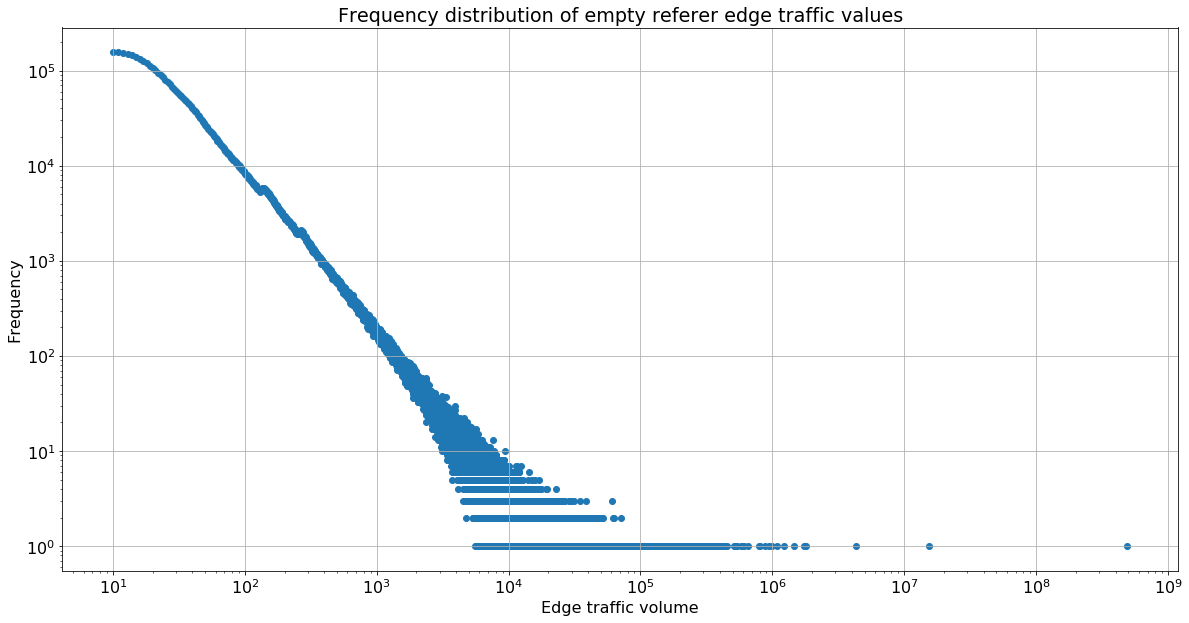

In [447]:
plt.scatter(empty_referer_edges_freq.index.values, empty_referer_edges_freq.values)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Edge traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of empty referer edge traffic values");

In [448]:
empty_referer_edges.head(20)

,prev,curr,type,n
7908180,other-empty,Main_Page,external,492341152
765759,other-empty,Hyphen-minus,external,15498618
3488262,other-empty,XHamster,external,4281194
17100674,other-empty,Darth_Vader,external,1801074
9889788,other-empty,Segersjön,external,1724261
1395258,other-empty,Lists_of_deaths_by_year,external,1457060
20816436,other-empty,Exo_(band),external,1223507
11283146,other-empty,2018_FIFA_World_Cup,external,1077101
23951884,other-empty,Jason_Momoa,external,990366
6365678,other-empty,Null,external,944711


##### External websites reference category

In [449]:
external_websites_edges = external_edges[external_edges.prev == "other-external"]
external_websites_edges.describe(include="all")

,prev,curr,type,n
count,787311,787311,787311,787311.00
unique,1,787311,1,nan
top,other-external,Jasper_Liu,external,nan
freq,787311,1,787311,nan
mean,NaN,NaN,NaN,148.27
std,NaN,NaN,NaN,19997.55
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,15.00
50%,NaN,NaN,NaN,27.00
75%,NaN,NaN,NaN,66.00


In [450]:
external_websites_edges_freq = external_websites_edges.n.value_counts()

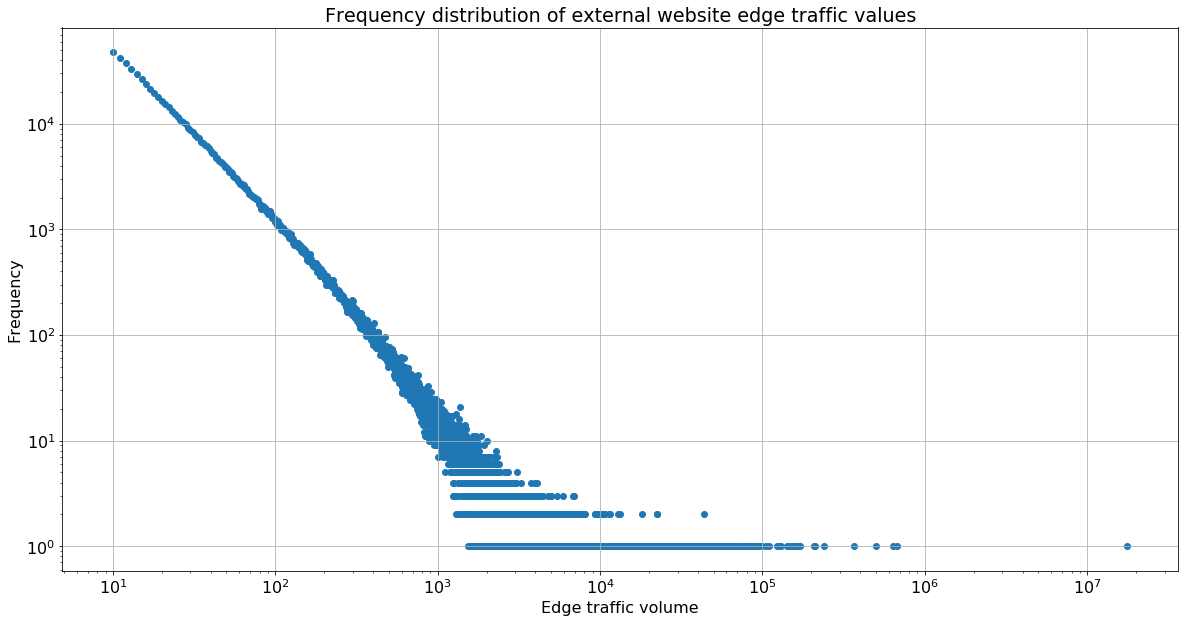

In [451]:
plt.scatter(external_websites_edges_freq.index.values, external_websites_edges_freq.values)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Edge traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of external website edge traffic values");

In [452]:
external_websites_edges.head(20)

,prev,curr,type,n
772288,other-external,Hyphen-minus,external,17676430
7911237,other-external,Main_Page,external,677294
17715549,other-external,HTTP_404,external,636210
7013418,other-external,Toilet-related_injuries_and_deaths,external,499771
9345692,other-external,Kotii_Reddy,external,365723
4678252,other-external,Vilnius,external,239233
13233515,other-external,OpenText,external,209113
2365108,other-external,Singapore,external,209027
21826646,other-external,China,external,169522
5577541,other-external,2015_Tianjin_explosions,external,168136


I've no idea why the Wikipedia articles for hyphen and toilet-related deaths would be in the top 5 external website links by traffic volume. ¯\\_(ツ)_/¯

##### Other Wikimedia websites reference category

In [453]:
other_wikimedia_edges = external_edges[external_edges.prev == "other-internal"]
other_wikimedia_edges.describe(include="all")

,prev,curr,type,n
count,1348892,1348892,1348892,1348892.00
unique,1,1348892,1,nan
top,other-internal,Jim_Houghton,external,nan
freq,1348892,1,1348892,nan
mean,NaN,NaN,NaN,98.12
std,NaN,NaN,NaN,7675.69
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,14.00
50%,NaN,NaN,NaN,24.00
75%,NaN,NaN,NaN,57.00


In [454]:
other_wikimedia_edges_freq = other_wikimedia_edges.n.value_counts()

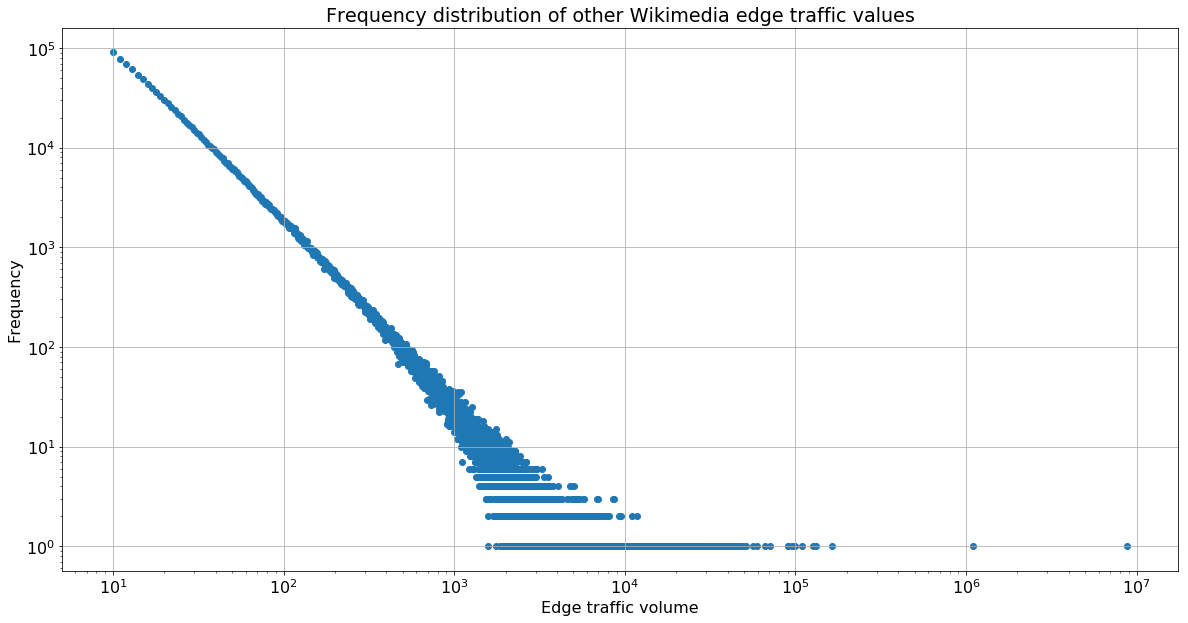

In [455]:
plt.scatter(other_wikimedia_edges_freq.index.values, other_wikimedia_edges_freq.values)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Edge traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of other Wikimedia edge traffic values");

In [456]:
other_wikimedia_edges.head(20)

,prev,curr,type,n
7831692,other-internal,Main_Page,external,8826536
718456,other-internal,Hyphen-minus,external,1102895
24135220,other-internal,NetScout_Systems,external,164599
5685679,other-internal,Aquaman_(film),external,131946
1830779,other-internal,Bird_Box_(film),external,127234
21252211,other-internal,George_H._W._Bush,external,109536
11460836,other-internal,Alfred_Werner_Maurer,external,99521
2804399,other-internal,Saleem_Dabbour,external,95989
1395045,other-internal,Lists_of_deaths_by_year,external,90288
26953883,other-internal,Spider-Man:_Into_the_Spider-Verse,external,89905


##### All other external references category

In [457]:
external_other_edges = external_edges[external_edges.prev == "other-other"]
external_other_edges.describe(include="all")

,prev,curr,type,n
count,374921,374921,374921,374921.00
unique,1,374921,1,nan
top,other-other,Jasper_Liu,external,nan
freq,374921,1,374921,nan
mean,NaN,NaN,NaN,98.61
std,NaN,NaN,NaN,582.40
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,15.00
50%,NaN,NaN,NaN,27.00
75%,NaN,NaN,NaN,66.00


In [458]:
external_other_edges_freq = external_other_edges.n.value_counts()

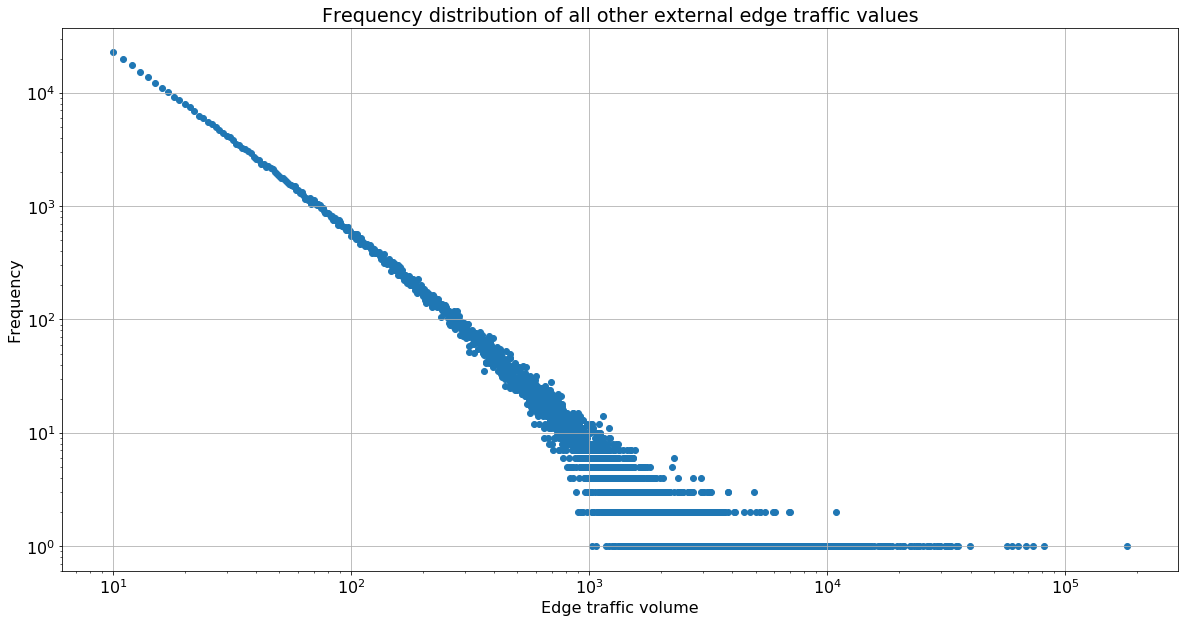

In [459]:
plt.scatter(external_other_edges_freq.index.values, external_other_edges_freq.values)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Edge traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of all other external edge traffic values");

In [460]:
external_other_edges.head(50)

,prev,curr,type,n
18403629,other-other,2.0_(film),external,182358
7864821,other-other,Main_Page,external,81647
62341,other-other,Zero_(2018_film),external,72911
800518,other-other,K.G.F:_Chapter_1,external,68387
11367499,other-other,List_of_highest-grossing_Indian_films,external,63234
1519345,other-other,Sexy_Movie,external,59806
26295856,other-other,XXXX,external,57086
27074482,other-other,List_of_Bollywood_films_of_2018,external,39626
4767645,other-other,Blue_Film_Woman,external,35363
4776132,other-other,Priyanka_Chopra,external,34612


#### "Other" reference edge traffic distribution  
(edges with type='other')
These are edges between Wikipedia articles that are not linked to each other. This can happen when a user searches Wikipedia from a Wikipedia article page, or it can result from referer spoofing (according to the [Wikipedia clickstream datasets format description](https://meta.wikimedia.org/wiki/Research:Wikipedia_clickstream#Format)).

In [461]:
other_edges = df_clean_sorted[df_clean_sorted.type == 'other']

In [462]:
other_edges.describe(include="all")

,prev,curr,type,n
count,1005180,1005180,1005180,1005180.00
unique,302292,414847,1,nan
top,Main_Page,Hyphen-minus,other,nan
freq,257794,127458,1005180,nan
mean,NaN,NaN,NaN,59.71
std,NaN,NaN,NaN,3080.46
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,12.00
50%,NaN,NaN,NaN,18.00
75%,NaN,NaN,NaN,35.00


In [463]:
other_edges_freq = other_edges.n.value_counts()

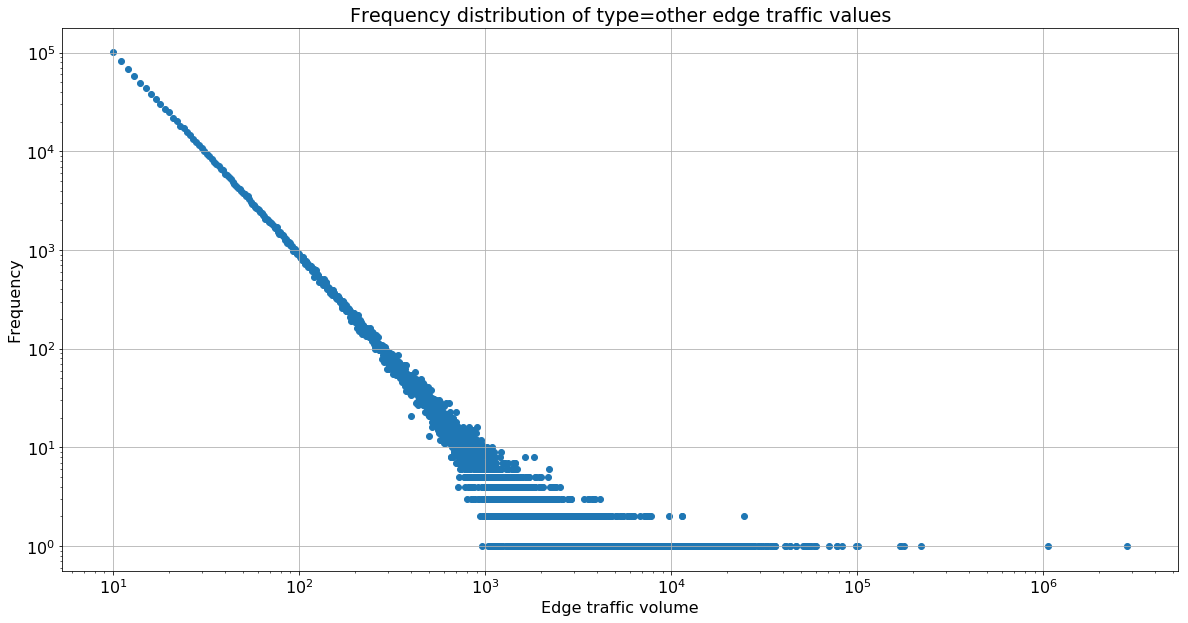

In [464]:
plt.scatter(other_edges_freq.index.values, other_edges_freq.values)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Edge traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of type=other edge traffic values");

In [465]:
other_edges.head(20)

,prev,curr,type,n
727986,Main_Page,Hyphen-minus,other,2838090
1395264,Main_Page,Lists_of_deaths_by_year,other,1065668
21252593,Main_Page,George_H._W._Bush,other,220667
15997541,Main_Page,Yellow_vests_movement,other,178234
21175288,Main_Page,Balangiga_bells,other,171702
6426095,Main_Page,Pineapple,other,170129
23370493,Main_Page,2018_Sunda_Strait_tsunami,other,100842
28097656,Main_Page,2018_Strasbourg_attack,other,98728
5564468,Main_Page,Voyager_2,other,83172
12932182,Main_Page,OSIRIS-REx,other,78426


In [481]:
edges_count = other_edges.groupby("prev").n.count()
edges_count.rename("edges_count", inplace=True)
traffic_volume = other_edges.groupby("prev").n.sum()
traffic_volume.rename("traffic_volume", inplace=True)
summary_by_prev = pd.concat([edges_count, traffic_volume], axis=1)

summary_by_prev["edges_count_pct"] = summary_by_prev["edges_count"] / summary_by_prev["edges_count"].sum()
summary_by_prev["traffic_volume_pct"] = summary_by_prev["traffic_volume"] / summary_by_prev["traffic_volume"].sum()

In [482]:
summary_by_prev.sort_values("traffic_volume_pct", ascending=False).head(10)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
prev,,,,
Main_Page,257794,32475706,0.26,0.54
Wiki,3778,138360,0.00,0.00
Welcome_to_Marwen,109,72643,0.00,0.00
George_H._W._Bush,377,70544,0.00,0.00
Ralph_Breaks_the_Internet,212,67236,0.00,0.00
Wikipedia,1998,59717,0.00,0.00
Jason_Momoa,183,50044,0.00,0.00
Aquaman_(film),588,46824,0.00,0.00
2.0_(film),255,46226,0.00,0.00


54% of searching within Wikipedia starts on the main page.

In [483]:
summary_by_prev.sort_values("edges_count_pct", ascending=False).head(10)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
prev,,,,
Main_Page,257794,32475706,0.26,0.54
Wiki,3778,138360,0.00,0.00
Wikipedia,1998,59717,0.00,0.00
Aquaman_(film),588,46824,0.00,0.00
English_Wikipedia,539,20313,0.00,0.00
Bird_Box_(film),413,29267,0.00,0.00
Spider-Man:_Into_the_Spider-Verse,407,31021,0.00,0.00
2018_in_film,394,13069,0.00,0.00
George_H._W._Bush,377,70544,0.00,0.00


In [484]:
edges_count = other_edges.groupby("curr").n.count()
edges_count.rename("edges_count", inplace=True)
traffic_volume = other_edges.groupby("curr").n.sum()
traffic_volume.rename("traffic_volume", inplace=True)
summary_by_prev = pd.concat([edges_count, traffic_volume], axis=1)

summary_by_prev["edges_count_pct"] = summary_by_prev["edges_count"] / summary_by_prev["edges_count"].sum()
summary_by_prev["traffic_volume_pct"] = summary_by_prev["traffic_volume"] / summary_by_prev["traffic_volume"].sum()

summary_by_prev.sort_values("traffic_volume_pct", ascending=False).head(10)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
curr,,,,
Hyphen-minus,127458,7557718,0.13,0.13
Main_Page,110009,4013760,0.11,0.07
Lists_of_deaths_by_year,275,1074677,0.00,0.02
George_H._W._Bush,228,226297,0.00,0.00
Yellow_vests_movement,25,178842,0.00,0.00
Balangiga_bells,2,171835,0.00,0.00
Pineapple,27,170638,0.00,0.00
2018_Sunda_Strait_tsunami,4,100893,0.00,0.00
2018_Strasbourg_attack,6,99298,0.00,0.00


In [485]:
summary_by_prev.sort_values("edges_count_pct", ascending=False).head(10)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
curr,,,,
Hyphen-minus,127458,7557718,0.13,0.13
Main_Page,110009,4013760,0.11,0.07
Aquaman_(film),711,87294,0.00,0.00
Spider-Man:_Into_the_Spider-Verse,510,61587,0.00,0.00
2018_in_film,415,38373,0.00,0.00
Bird_Box_(film),329,44264,0.00,0.00
Null,288,7813,0.00,0.00
Bumblebee_(film),284,34584,0.00,0.00
Lists_of_deaths_by_year,275,1074677,0.00,0.02


#### Link reference edge traffic distribution  
(edges with type='link')  
These are the edges between linked Wikipedia articles. These edges represent the aggregated user clickstream behavior. The `n` here represent a count of events where a user clicks on a link in a Wikipedia article to go visit another Wikipedia article.

In [486]:
link_edges = df_clean_sorted[df_clean_sorted.type == 'link']

In [487]:
link_edges.describe(include="all")

,prev,curr,type,n
count,17851574,17851574,17851574,17851574.00
unique,1703705,2598302,1,nan
top,New_York_City,United_States,link,nan
freq,2224,6368,17851574,nan
mean,NaN,NaN,NaN,96.26
std,NaN,NaN,NaN,870.84
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,14.00
50%,NaN,NaN,NaN,25.00
75%,NaN,NaN,NaN,56.00


In [488]:
link_edges_freq =link_edges.n.value_counts()

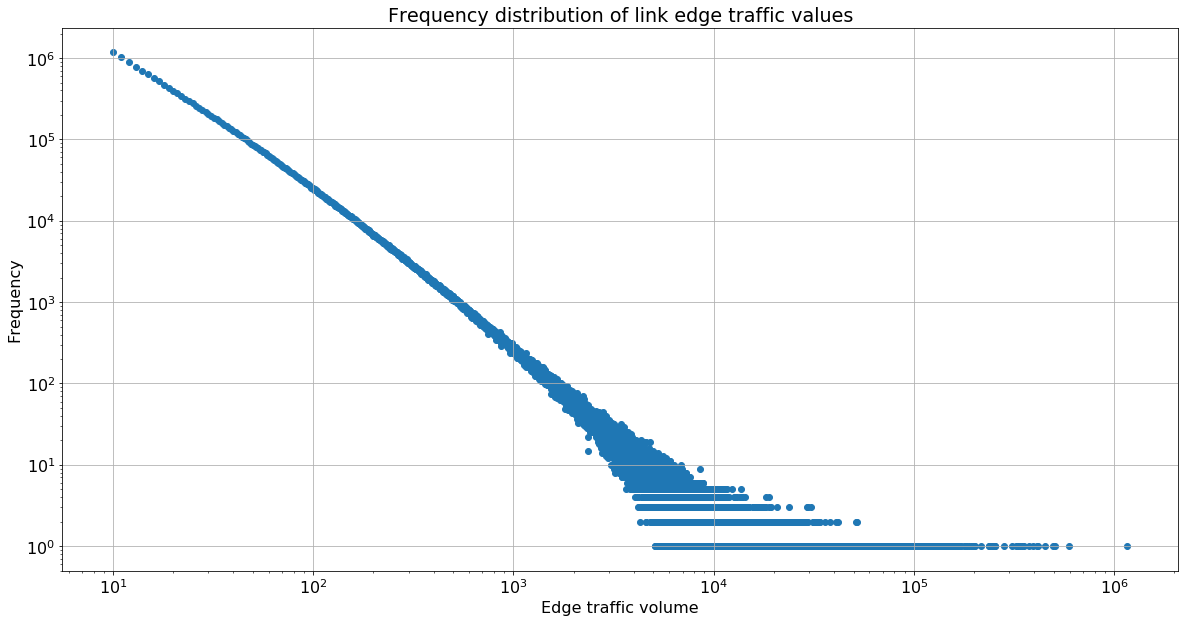

In [489]:
plt.scatter(link_edges_freq.index.values, link_edges_freq.values)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Edge traffic volume')
plt.ylabel('Frequency')
plt.grid(True)

plt.title("Frequency distribution of link edge traffic values");

In [490]:
link_edges.head(20)

,prev,curr,type,n
9722110,Jason_Momoa,Lisa_Bonet,link,1166522
6473638,Priyanka_Chopra,Nick_Jonas,link,596798
1830750,Bird_Box,Bird_Box_(film),link,508241
4776073,Nick_Jonas,Priyanka_Chopra,link,493898
23721511,George_H._W._Bush,George_W._Bush,link,453809
6531433,George_H._W._Bush,Pauline_Robinson_Bush,link,419132
18515291,George_H._W._Bush,Barbara_Bush,link,412565
21252092,George_W._Bush,George_H._W._Bush,link,393452
10588026,George_H._W._Bush,Dorothy_Bush_Koch,link,377785
365460,Emily_Atack,Kate_Robbins,link,354577


In [491]:
edges_count = link_edges.groupby("prev").n.count()
edges_count.rename("edges_count", inplace=True)
traffic_volume = link_edges.groupby("prev").n.sum()
traffic_volume.rename("traffic_volume", inplace=True)
summary_by_prev = pd.concat([edges_count, traffic_volume], axis=1)

summary_by_prev["edges_count_pct"] = summary_by_prev["edges_count"] / summary_by_prev["edges_count"].sum()
summary_by_prev["traffic_volume_pct"] = summary_by_prev["traffic_volume"] / summary_by_prev["traffic_volume"].sum()

In [493]:
pd.options.display.float_format = '{:.4f}'.format

In [494]:
summary_by_prev.sort_values("traffic_volume_pct", ascending=False).head(10)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
prev,,,,
George_H._W._Bush,811,4466936,0.0000,0.0026
Aquaman_(film),250,2391941,0.0000,0.0014
Jason_Momoa,96,2226611,0.0000,0.0013
Bird_Box_(film),67,2042949,0.0000,0.0012
Spider-Man:_Into_the_Spider-Verse,319,1872733,0.0000,0.0011
Exo_(band),129,1639704,0.0000,0.0010
Macaulay_Culkin,164,1441673,0.0000,0.0008
George_W._Bush,562,1343059,0.0000,0.0008
Priyanka_Chopra,423,1245686,0.0000,0.0007


In [495]:
summary_by_prev.sort_values("edges_count_pct", ascending=False).head(10)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
prev,,,,
New_York_City,2224,196519,0.0001,0.0001
London,2061,170028,0.0001,0.0001
William_Shakespeare,2043,231056,0.0001,0.0001
Russia,2039,225218,0.0001,0.0001
California,2039,135372,0.0001,0.0001
France,1874,173974,0.0001,0.0001
United_States,1815,557659,0.0001,0.0003
Paris,1804,106901,0.0001,0.0001
Massachusetts,1753,88968,0.0001,0.0001


In [496]:
edges_count = link_edges.groupby("curr").n.count()
edges_count.rename("edges_count", inplace=True)
traffic_volume = link_edges.groupby("curr").n.sum()
traffic_volume.rename("traffic_volume", inplace=True)
summary_by_prev = pd.concat([edges_count, traffic_volume], axis=1)

summary_by_prev["edges_count_pct"] = summary_by_prev["edges_count"] / summary_by_prev["edges_count"].sum()
summary_by_prev["traffic_volume_pct"] = summary_by_prev["traffic_volume"] / summary_by_prev["traffic_volume"].sum()

summary_by_prev.sort_values("traffic_volume_pct", ascending=False).head(10)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
curr,,,,
Lisa_Bonet,53,1217004,0.0000,0.0007
George_H._W._Bush,956,1108189,0.0001,0.0006
George_W._Bush,1002,907853,0.0001,0.0005
Nick_Jonas,152,776311,0.0000,0.0005
Bird_Box_(film),42,682992,0.0000,0.0004
Jason_Momoa,91,639353,0.0000,0.0004
Dorothy_Bush_Koch,34,605207,0.0000,0.0004
Avengers:_Endgame,230,603912,0.0000,0.0004
Zoë_Kravitz,90,598633,0.0000,0.0003


In [497]:
summary_by_prev.sort_values("edges_count_pct", ascending=False).head(10)

,edges_count,traffic_volume,edges_count_pct,traffic_volume_pct
curr,,,,
United_States,6368,403347,0.0004,0.0002
India,3855,203531,0.0002,0.0001
United_Kingdom,3166,228569,0.0002,0.0001
World_War_II,2578,145984,0.0001,0.0001
New_York_City,2385,143048,0.0001,0.0001
YouTube,2375,132473,0.0001,0.0001
Los_Angeles,2078,93011,0.0001,0.0001
China,2045,129257,0.0001,0.0001
IMDb,2032,52762,0.0001,0.0000


### 5. DQA summary  
There are 140 monthly Wikipedia clickstream datasets available as of January 2019, spanning 11 language domains and a little over a year's worth of data. The clickstream edges are aggregated at both article level for internal Wikipedia articles and a more general website category level for external referers to Wikipedia articles, which is likely to affect further analyses, so these aggregation levels will need to be addressed.  
The edge traffic volume appears to follow power law distribution, especially when the edges are split up by reference type.  
There are no missing values in the data.  
The data has embedded double quotes, escape characters and other special characters. The escape chars and double quotes need to be escaped when importing the data to Pandas and/or neo4j.  
The data also has valid "NaN" string values, which Pandas reads in as missing values. 

#### Data cleaning steps to do for each raw dataset  
1. Escape the escape char and double quotes in the raw datafile in bash.  
2. After reading the data into Pandas, replace Pandas' Nan missing values with "NaN" string.
4. Split up the edges data by reference type.

### 6. Next steps  

The clickstream datasets are very large, and it is more feasible to analyse one dataset at a time. The English Wikipedia is the largest, with the most clickstream activity, and it is a good place to start exploring Wikipedia clickstream patterns.  
In the next steps, we'll take a close look at the English Wikipedia clickstream dataset for December 2018, starting with a basic [exploratory data analysis of clickstream edges set](./English_Wikipedia_EDA.ipynb). 